In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Single Feature Classification Problem

In [17]:
np.random.seed(42)
n_samples = 1_000_000
x1 = np.random.uniform(0, 4, n_samples)
y = ( x1 - 2 ) ** 2 + np.random.normal(0, 1, n_samples) + 10
df = pd.DataFrame({'x1': x1, 'y': y})

In [18]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 2, 3, 3.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() )

In [19]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )

In [20]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist()}

In [23]:
probs = 1 / (1 + np.exp(-(df['y'] - 16)))
df['binary_y'] = np.random.binomial(1, probs)
print(df['binary_y'].mean())

0.027855


In [24]:
from quantbullet.optimizer import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-6, gtol=1e-6, eps=1e-3)

In [25]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, verbose=True )

Using initial params: [0.00214247 0.00214247 0.00214247 0.00214247 0.00214247 0.00214247
 0.00214247]
Iter 1: 127261.10057721662
Iter 2: 125799.53362650103
Iter 3: 122985.00621490927
Iter 4: 121095.14391804101
Iter 5: 120065.68493214596
Iter 6: 119791.09799528835
Iter 7: 117914.00949390791
Iter 8: 116363.68739125597
Iter 9: 115672.63127213562
Iter 10: 115156.53680837055
Iter 11: 114870.48238467282
Iter 12: 114718.83014703545
Iter 13: 114564.42506748163
Iter 14: 114304.82151588265
Iter 15: 113422.27963576556
Iter 16: 113337.86615593033
Iter 17: 113095.093828694
Iter 18: 112942.79262188218
Iter 19: 112767.89908556815
Iter 20: 112736.87118050783
Iter 21: 112717.04053050188
Iter 22: 112689.7208958652
Iter 23: 112634.25696052858
Iter 24: 112337.09229725934
Iter 25: 112283.44604199441
Iter 26: 111906.78713361107
Iter 27: 111644.34420640118
Iter 28: 111493.12831242102
Iter 29: 111470.35036686616
Iter 30: 111469.26612723348
Iter 31: 111459.31822888233
Iter 32: 111458.5213053347
Iter 33: 111458

In [26]:
lpc_scipy.coef_

array([-0.6869807 , -0.20704419, -0.04184417, -0.00554104,  0.00572383,
        0.04052395,  0.20386795])

In [27]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict_proba(train_df)

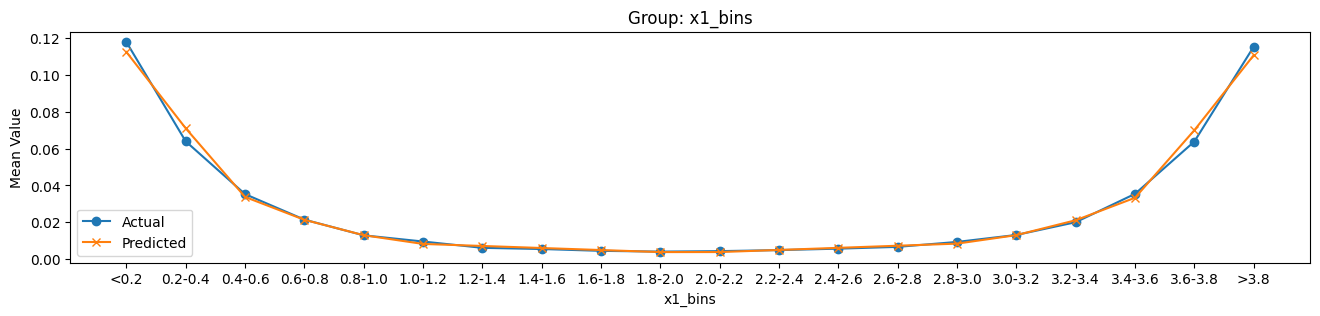

In [28]:
for group in ['x1_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()